In [1]:
from __future__ import print_function, division
#virtualenv -p python3 venv

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cPickle as pk
import pandas as pd
import numpy as np
from IPython.display import clear_output

In [3]:
import os
import sys
base_module_path = os.path.abspath(os.path.join('..'))
if base_module_path not in sys.path:
    sys.path.append(base_module_path)
import cervix as c

Using TensorFlow backend.


In [4]:
ls ../data/train/

Type_1/  Type_2/  Type_3/


In [5]:
df = c.data.make_base_df()
df = c.processing.transform_save_imgs(df, c.processing.resize_n, n=224);

In [6]:
train, validate = c.data.split_df(df); 

In [7]:
print(train.shape)
train.head()

(1332, 5)


,path,Type,filetype,num_id,processed_path
137,../data/train/Type_1/102.jpg,1,jpg,102,../data/processed/resize_224/train/102.jpg
130,../data/train/Type_1/1105.jpg,1,jpg,1105,../data/processed/resize_224/train/1105.jpg
1032,../data/train/Type_3/573.jpg,3,jpg,573,../data/processed/resize_224/train/573.jpg
177,../data/train/Type_1/1389.jpg,1,jpg,1389,../data/processed/resize_224/train/1389.jpg
1303,../data/train/Type_3/1048.jpg,3,jpg,1048,../data/processed/resize_224/train/1048.jpg


In [8]:
print(validate.shape)
validate.head()

(149, 5)


,path,Type,filetype,num_id,processed_path
1453,../data/train/Type_3/670.jpg,3,jpg,670,../data/processed/resize_224/train/670.jpg
1202,../data/train/Type_3/427.jpg,3,jpg,427,../data/processed/resize_224/train/427.jpg
1403,../data/train/Type_3/635.jpg,3,jpg,635,../data/processed/resize_224/train/635.jpg
162,../data/train/Type_1/230.jpg,1,jpg,230,../data/processed/resize_224/train/230.jpg
625,../data/train/Type_2/1329.jpg,2,jpg,1329,../data/processed/resize_224/train/1329.jpg


# Model creation

In [12]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers.core import Reshape
from keras import backend as K

# create the base pre-trained model
base_model = VGG16(weights=None, include_top=False)

# remove most of VGG16 to leave only the first two conv blocks (basic features)
#ie remove top 12 layers
for _ in range(4):
    base_model.layers.pop()
base_model = Model(base_model.input, base_model.layers[-1].output)

# add a global spatial average pooling layer
x = base_model.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Reshape((None,512)(x)
# and a logistic layer -- let's say we have 200 classes
    # we have three classes so usung 3 on dense predictions
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

SyntaxError: invalid syntax (<ipython-input-12-447beeeee9f4>, line 25)

In [94]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    
model.summary()

0 input_12
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 dense_23
16 dense_24
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
____________________________

In [88]:
#Choosing to train blocks 4 and 5
for layer in model.layers[:1]:
    layer.trainable = False
for layer in model.layers[1:]:
    layer.trainable = True
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_12 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 dense_23 True
16 dense_24 True


In [89]:
# compile the model (should be done *after* setting layers to non-trainable)
# TODO: loss function should be log loss. 'categorical_crossentropy' / c.submission.keras_log_loss
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [81]:
features, labels = c.processing.df_to_training_tuples(train, (224, 224, 3), grayscale=False)
val_data = c.processing.df_to_training_tuples(validate, (224,224, 3), grayscale=False)

In [82]:
history = c.analysis.History()

In [90]:
# train the model on the new data for a few epochs
import keras
print('backend : '+keras.backend.backend())
model_history = model.fit(features, labels, batch_size=34, epochs=100, validation_data=val_data,
                          callbacks=[history, keras.callbacks.EarlyStopping(patience=5)])


backend : tensorflow


ValueError: Error when checking target: expected dense_24 to have 4 dimensions, but got array with shape (1332, 3)

In [74]:
model.save('../model/vgg_4blocks_fullytrained.hk')

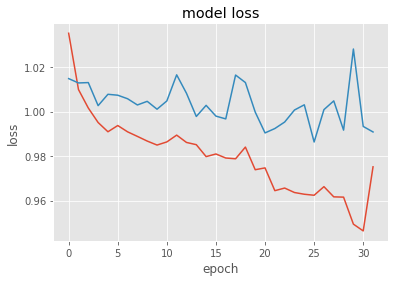

In [63]:
c.analysis.plot_log_errors(history)

In [ ]:
batch_size_t = 1
predictions = model.predict_generator(c.processing.df_to_keras_generator(test, batch_size_t, grayscale=False)
                    ,len(test))
predictions

In [ ]:
test_p = c.processing.append_probabilities(test, predictions, ['1','2','3']); test_p.head()

In [ ]:
test_p.Type.value_counts()

In [ ]:
predictions.sum(0)

In [ ]:
score, ldf = c.submission.compute_losses(test_p)

In [ ]:
score

In [ ]:
ldf.sort_values('Type_1', ascending=False)

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[0])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[0])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[1])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[1])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[3])

In [ ]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[3])